In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 读取CSV文件
file_path = 'world_place.csv'
world_places_df = pd.read_csv(file_path)

# 显示数据集的前几行以了解其结构
print("Data preview:")
print(world_places_df.head())

# 筛选出页面浏览量大于5000的地点
filtered_places_df = world_places_df[world_places_df['page_views'] >= 5000]

# 提取地点名称和对应的地理坐标
places = filtered_places_df['name'].tolist()
coordinates = filtered_places_df[['latitude', 'longitude']].values

# 划分训练集和测试集
places_train, places_test, coords_train, coords_test = train_test_split(
    places, coordinates, test_size=0.2, random_state=42
)

# 为Qwen生成输入格式
def format_input_for_llama(place_name):
    prompt = f"What are the geographic coordinates of {place_name}?"
    return prompt

# 生成训练和测试集的输入
inputs_train = [format_input_for_llama(place) for place in places_train]
inputs_test = [format_input_for_llama(place) for place in places_test]

# 查看生成的部分输入和对应坐标
print("Sample formatted inputs for training:")
for i in range(5):
    print(f"Input: {inputs_train[i]}, Coordinates: {coords_train[i]}")

print("Number of training samples:", len(inputs_train))
print("Number of testing samples:", len(inputs_test))


Data preview:
                                                name           entity_subtype  \
0  Tancredo Neves Pantheon of the Fatherland and ...                 Monument   
1                                    Sembuwatta Lake  AmusementParkAttraction   
2                                       Ford Rotunda  AmusementParkAttraction   
3                                        Afsluitdijk                   Bridge   
4                                    Mudeirej Bridge                   Bridge   

         country  latitude  longitude  has_thumbnail  page_views entity_type  \
0         Brazil -15.80170  -47.86030              1      7521.0   structure   
1      Sri_Lanka   7.43694   80.69970              1     16340.0   structure   
2  United_States  42.31210  -83.17670              1     40773.0   structure   
3    Netherlands  53.00000    5.16667              1    227321.0   structure   
4        Lebanon  33.80080   35.72710              1      5623.0   structure   

   total_area  pop

In [3]:
!pip install geopandas

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 81.2 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 66.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 92.2 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.8.4
    Uninstalling Shapely-1.8.4:
      Successfully uninstalled Shapely-1.8.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pai-easycv 0.11.6 requires shapely==1.8.4, but you have shapely 2.0.5 which is incompatible.
pai-easycv 0.11.6 requires timm==0.5.4, but you have timm 1.0.8 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, ru

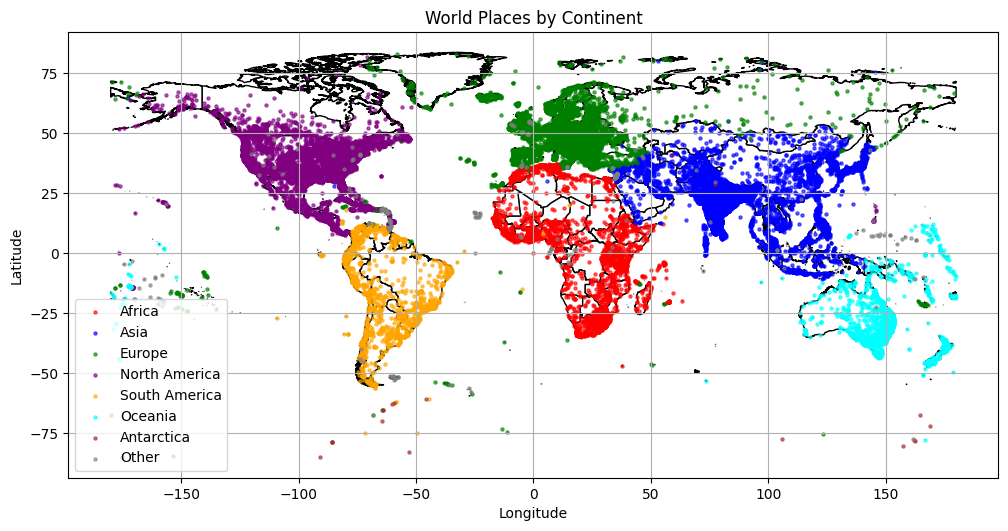

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd


# 读取CSV文件
world_places_df = pd.read_csv('world_place.csv')

# 筛选出页面浏览量大于5000的地点
filtered_places_df = world_places_df[world_places_df['page_views'] >= 5000]

# 确定大洲划分规则
def get_continent(country):
    continent_mapping = {
        "Africa": ["Algeria", "Angola", "Benin", "Botswana", "Burkina_Faso", "Burundi", "Cabo_Verde", "Cameroon", "Central_African_Republic",
                   "Chad", "Comoros", "Congo", "Djibouti", "Egypt", "Equatorial_Guinea", "Eritrea", "Eswatini", "Ethiopia", "Gabon", "Gambia",
                   "Ghana", "Guinea", "Guinea-Bissau", "Ivory_Coast", "Kenya", "Lesotho", "Liberia", "Madagascar", "Malawi", "Mali", "Mauritania",
                   "Mauritius", "Morocco", "Mozambique", "Namibia", "Niger", "Nigeria", "Rwanda", "Sao_Tome_and_Principe", "Senegal", "Seychelles",
                   "Sierra_Leone", "Somalia", "South_Africa", "South_Sudan", "Sudan", "Tanzania", "Togo", "Uganda", "Zambia", "Zimbabwe","Democratic_Republic_of_the_Congo",
                   "Cape_Town,_South_Africa","Tunisia","Libya","Sahrawi_Arab_Democratic_Republic","Somaliland","Somalia_","Old_Cairo","The_Gambia","Western_Sahara",
                   "Puntland","Democratic_Republic_of_Congo","DR_Congo","ملف:Flag_of_Sudan.svg"],
        "Asia": ["Afghanistan", "Armenia", "Azerbaijan", "Bahrain", "Bangladesh", "Bhutan", "Brunei", "Cambodia", "China", "Cyprus", "Georgia",
                 "India", "Indonesia", "Iran", "Iraq", "Israel", "Japan", "Jordan", "Kazakhstan", "Kuwait", "Kyrgyzstan", "Laos", "Lebanon",
                 "Malaysia", "Maldives", "Mongolia", "Myanmar", "Nepal", "North Korea", "Oman", "Pakistan", "Philippines", "Qatar", "Saudi_Arabia",
                 "Singapore", "South_Korea", "Sri_Lanka", "Syria", "Taiwan", "Tajikistan", "Thailand", "Timor-Leste", "Turkmenistan", "United_Arab_Emirates",
                 "Uzbekistan", "Vietnam", "Yemen","People's_Republic_of_China","Hong_Kong","North_Korea","Republic_of_China","Burma","Russian_Federation",
                 "List_of_World_Heritage_Sites_in_the_Philippines","State_of_Palestine","Republic_of_Korea","Macau","East_Timor","Russian_Empire","Republic_of_China_(Taiwan)",
                 "Myanmar_(Burma)","Ngau_Tau_Kok","Kwun_Tong","india","Kashmir","Golan_Heights","Nippon_Sei_Ko_Kai","Myanmar_(Burma)","Palestinian_Territories"],
        "Europe": ["Albania", "Andorra", "Austria", "Belarus", "Belgium", "Bosnia_and_Herzegovina", "Bulgaria", "Croatia", "Czech Republic", "Denmark",
                   "Estonia", "England","Finland", "France", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg",
                   "Malta", "Moldova", "Monaco", "Montenegro", "Netherlands", "North_Macedonia", "Norway", "Poland", "Portugal", "Romania", "Russia",
                   "San_Marino", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Ukraine", "United_Kingdom", "Vatican City","French_Polynesia",
                   "Wales","Northern_Ireland","Scotland","Republic_of_Ireland","Turkey","England,_United_Kingdom","Czech_Republic","De_facto","Malta_Colony",
                   "Great_Britain","UK","Puerto_Rico","Isle_of_Man","Greenland","Kosovo","East_Germany","Jersey","Georgia_(country)","Kingdom_of_Spain","Church_in_Wales",
                   "Gloucestershire","Vatican_City","Kingdom_of_England","Papal_States","Channel_Islands","Faroe_Islands","Nazi_Germany","Achaemenid_Empire",
                   "United_Kingdom_of_Great_Britain_and_Ireland","Kingdom_of_Great_Britain","Kent","Kingdom_of_Italy","West_Sussex","Devon","Derbyshire",
                   "Leicestershire","Oxfordshire","Staffordshire","Hampshire","Surrey","Cambridgeshire","North_Yorkshire","Bosnia_&_Herzegovina","Lancashire",
                   "Somerset","Nottinghamshire","Warwickshire","Cumbria","Norfolk","Essex","Worcestershire","Suffolk","Lincolnshire","Hertfordshire","Rutland",
                   "East_Sussex","Northamptonshire","Dorset","Danish_Realm","Minsk_Raion","Liechtenstein","Kingdom_of_Romania","Channel_Islands","Kingdom_of_Denmark",
                   "French_Republic","Kingdom_of_the_Netherlands","Guernsey","German_Democratic_Republic","Leicestershire","Oxfordshire","Staffordshire","Hampshire",
                   "Surrey","Cambridgeshire","North_Yorkshire","Bosnia_&_Herzegovina","Lancashire","Somerset","Nottinghamshire","Warwickshire","Cumbria","Norfolk",
                   "Essex","Worcestershire","Suffolk","Lincolnshire","Hertfordshire"],
        "North America": ["North_Rustico,_Prince_Edward_Island","Crow_Nation","United_States_of_America","Antigua_and_Barbuda", "Bahamas", "Barbados", "Belize", "Canada", "Costa_Rica", "Cuba", "Dominica", "Dominican_Republic",
                          "El_Salvador", "Grenada", "Guatemala", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama", "Saint_Kitts_and_Nevis",
                          "Saint_Lucia", "Saint Vincent and the Grenadines", "Trinidad and Tobago", "United_States","Bermuda","Crow_Nation"],
        "South America": ["Curaçao","Argentina", "Bolivia", "Brazil", "Chile", "Colombia", "Ecuador", "Guyana", "Paraguay", "Peru", "Suriname", "Uruguay", "Venezuela"],
        "Oceania": ["Australia", "Fiji", "Kiribati", "Marshall_Islands", "Micronesia", "Nauru", "New_Zealand", "Palau", "Papua_New_Guinea", "Samoa",
                    "Solomon_Islands", "Tonga", "Tuvalu", "Vanuatu"],
        "Antarctica": ["Antarctica"]
    }
    for continent, countries in continent_mapping.items():
        if country in countries:
            return continent
    return "Other"

# 为每个地点确定其大洲
filtered_places_df['continent'] = filtered_places_df['country'].apply(get_continent)


# 颜色映射
continent_colors = {
    "Africa": "red",
    "Asia": "blue",
    "Europe": "green",
    "North America": "purple",
    "South America": "orange",
    "Oceania": "cyan",
    "Antarctica": "brown",
    "Other": "gray"
}

geojson_path = 'WB_countries_Admin0_lowres.geojson'
gdf = gpd.read_file(geojson_path)

# 创建一个新的绘图窗口
fig, ax = plt.subplots(figsize=(12, 8))

# 绘制GeoDataFrame
gdf.plot(ax=ax, color='white', edgecolor='black', linewidth=1)

# 设置标题和标签
ax.set_title('GeoJSON Map', fontsize=15)


# 绘制地点
for continent, color in continent_colors.items():
    subset = filtered_places_df[filtered_places_df['continent'] == continent]
    plt.scatter(subset['longitude'], subset['latitude'], label=continent, color=color, alpha=0.6,s=5)

plt.title("World Places by Continent")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
from modelscope import AutoModelForCausalLM, AutoTokenizer
from modelscope import GenerationConfig

# Note: The default behavior now has injection attack prevention off.
tokenizer = AutoTokenizer.from_pretrained("qwen/Qwen-7B-Chat", trust_remote_code=True)

# use bf16
# model = AutoModelForCausalLM.from_pretrained("qwen/Qwen-7B-Chat", device_map="auto", trust_remote_code=True, bf16=True).eval()
# use fp16
# model = AutoModelForCausalLM.from_pretrained("qwen/Qwen-7B-Chat", device_map="auto", trust_remote_code=True, fp16=True).eval()
# use cpu only
# model = AutoModelForCausalLM.from_pretrained("qwen/Qwen-7B-Chat", device_map="cpu", trust_remote_code=True).eval()
# use auto mode, automatically select precision based on the device.
model = AutoModelForCausalLM.from_pretrained("qwen/Qwen-7B-Chat", device_map="auto", trust_remote_code=True).eval()

# Specify hyperparameters for generation. But if you use transformers>=4.32.0, there is no need to do this.
# model.generation_config = GenerationConfig.from_pretrained("Qwen/Qwen-7B-Chat", trust_remote_code=True) # 可指定不同的生成长度、top_p等相关超参

# 第一轮对话 1st dialogue turn
response, history = model.chat(tokenizer, "你好", history=None)
print(response)

2024-08-09 13:57:56.407994: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 13:57:56.447667: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 13:57:57.178557: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-09 13:57:58,162 - modelscope - WARNING - Model revision not specified, use revision: v1.1.9
Downloading: 100%|██████████| 8.21k/8.21k [00:00<00:00, 11.8kB/s]
Downloading: 100%|██████████| 50.8k/50.8k [00:00<00:00, 98.5kB/s]
Downloading: 100%|

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


你好！很高兴能够与你聊天。有什么我可以帮助你的吗？


In [6]:
import torch
# 定义提取激活值的函数
def get_activations(place_name):
    inputs = tokenizer(place_name, return_tensors="pt")
    input_ids = inputs.input_ids.to(model.device)

    last_hidden_states = []

    def hook(module, input, output):
        last_hidden_states.append(output[0].to(torch.float32))  # 转换为Float32类型

    # 注册钩子到模型的最后一层
    hook_handle = model.transformer.h[-1].register_forward_hook(hook)

    with torch.no_grad():
        model(input_ids)

    # 移除钩子
    hook_handle.remove()

    # 提取并返回激活值，确保一致的形状
    activations = last_hidden_states[0].squeeze(0).cpu().numpy()
    
    # 获取最后一个标记的激活值
    last_token_activations = activations[-1]

    return last_token_activations

In [7]:
import numpy as np
from tqdm import tqdm  # 导入 tqdm 库用于显示进度条

# 生成每个地点的激活值并显示进度
train_activations = np.array([get_activations(input_text) for input_text in tqdm(inputs_train, desc="Calculating Train Activations")])
# 生成每个地点的激活值并显示进度
test_activations = np.array([get_activations(input_text) for input_text in tqdm(inputs_test, desc="Calculating Test Activations")])


# 确认激活值的形状
print("Activation shape for one input:", train_activations[0].shape+test_activations[0].shape)



Calculating Test Activations: 100%|██████████| 7917/7917 [04:52<00:00, 27.09it/s]

Activation shape for one input: (4096, 4096)


In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

# 使用计算好的激活值
X_train = train_activations
y_train = coords_train
X_test = test_activations
y_test = coords_test

# 创建并训练线性岭回归模型
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# 预测并评估模型
y_pred = ridge_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2}")
print(f"Mean Squared Error: {mse}")


R² Score: 0.8203353294733968
Mean Squared Error: 597.5390127919185


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.96719e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [9]:
# 创建一个字典来存储每个名称首次出现的索引
name_to_index = {}

# 遍历filtered_places_df，记录每个名称第一次出现的索引
for idx, row in filtered_places_df.iterrows():
    name = row['name']
    if name not in name_to_index:
        name_to_index[name] = idx

# 从测试集中匹配名称并获取对应的索引
test_indices = [name_to_index[name] for name in places_test if name in name_to_index]

# 确认长度一致
print("测试集长度:", len(places_test))
print("匹配索引长度:", len(test_indices))

# 获取测试集中的大洲信息
continents_test = filtered_places_df.loc[test_indices, 'continent'].values

# 检查是否所有测试集数据都找到了对应的索引
assert len(test_indices) == len(places_test), "测试集中的某些名称未能找到唯一匹配的索引"


测试集长度: 7917
匹配索引长度: 7917


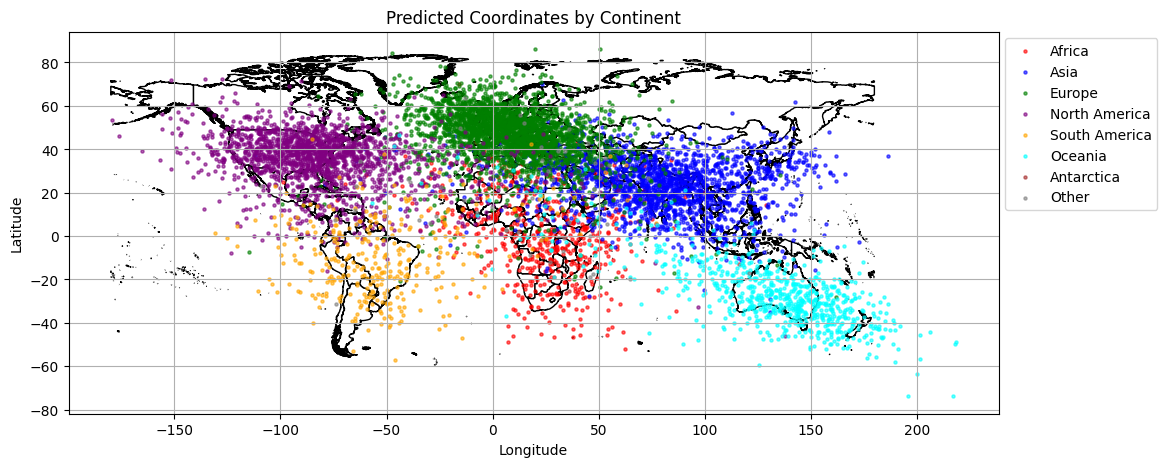

In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd

# 确认测试集预测和大洲信息长度相同
assert len(y_pred) == len(continents_test), "预测结果和大洲信息的长度不匹配"

# 定义一个函数来根据大洲绘制预测坐标
def plot_predictions_by_continent(y_pred, continents):
    # 创建一个新的绘图窗口
    fig, ax = plt.subplots(figsize=(12, 8))
    # 读取GeoJSON文件
    geojson_path = 'WB_countries_Admin0_lowres.geojson'
    gdf = gpd.read_file(geojson_path)

    # 绘制GeoDataFrame
    gdf.plot(ax=ax, color='white', edgecolor='black', linewidth=1)

    # 设置标题和标签
    ax.set_title('GeoJSON Map', fontsize=15)
    # 定义大洲颜色映射
    continent_colors = {
        "Africa": "red",
        "Asia": "blue",
        "Europe": "green",
        "North America": "purple",
        "South America": "orange",
        "Oceania": "cyan",
        "Antarctica": "brown",
        "Other": "gray"
    }

    # 绘制预测坐标
    for continent, color in continent_colors.items():
        mask = (continents == continent)
        plt.scatter(y_pred[mask, 1], y_pred[mask, 0], label=continent, color=color, alpha=0.6,s=5)
    
    plt.title("Predicted Coordinates by Continent")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()

# 绘制测试集预测的坐标
plot_predictions_by_continent(y_pred, continents_test)
